# Load Data

In [1]:
!pip install kaggle

In [36]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,ConfusionMatrixDisplay
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import matplotlib.pyplot as plt

In [6]:
path = kagglehub.dataset_download("yashpaloswal/fraud-detection-credit-card")
print("Path to dataset files:", path)

for filename in os.listdir(path):
    if filename.endswith(".csv"):
        filepath = os.path.join(path, filename)
        try:
            df = pd.read_csv(filepath)
            print(f"Successfully loaded {filename} into a DataFrame.")
            break
        except pd.errors.ParserError:
            print(f"Error parsing {filename}. Skipping this file.")
        except Exception as e:
            print(f"An error occurred while loading {filename}: {e}")

df_backup = df.copy()

Path to dataset files: /kaggle/input/fraud-detection-credit-card
Successfully loaded creditcard.csv into a DataFrame.


# Preprocessing

In [7]:
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

In [8]:
# Temporal train-test split
split_time = df['Time'].quantile(0.8)
train_df = df[df['Time'] <= split_time]
test_df = df[df['Time'] > split_time]

X_train = train_df.drop(columns=['class'])
y_train = train_df['class']
X_test = test_df.drop(columns=['class'])
y_test = test_df['class']

print(X_train)

            Time        V1        V2        V3        V4        V5        V6  \
0      -1.996583 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1      -1.996583  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2      -1.996562 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3      -1.996562 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4      -1.996541 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   
...          ...       ...       ...       ...       ...       ...       ...   
227840  1.061954  2.028950 -0.374089 -1.268051  0.349127 -0.057977 -0.515489   
227841  1.061975  0.306600  1.116021 -0.047348  3.593785  2.079047  5.748707   
227842  1.061975 -1.781954  2.062680 -3.758871 -1.801001 -0.084365  1.919610   
227843  1.061975 -0.061507  1.024900 -0.170060 -0.263220  0.982164 -1.162749   
227844  1.062017  2.050034 -0.103557 -1.204713  0.207198  0.108850 -0.665621   

              V7        V8        V9  .

# Run Function

In [9]:
# Function used to run a model

def run_model(df, model, name):

      print(f"\n Model: {name}")
      model.fit(X_resampled, y_resampled)
      y_pred = model.predict(X_test)

      cm = confusion_matrix(y_test, y_pred)
      cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
      cm_display.plot(cmap='Blues')
      plt.title(f"Confusion Matrix for {model.__class__.__name__}")
      plt.show()

      print("\nClassification Report:")
      print(classification_report(y_test, y_pred))


      if hasattr(model, "predict_proba"):
          y_scores = model.predict_proba(X_test)[:, 1]
      else:
          y_scores = model.decision_function(X_test)

      fpr, tpr, _ = roc_curve(y_test, y_scores)
      auc = roc_auc_score(y_test, y_scores)

      plt.figure()
      plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
      plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'ROC Curve for {name}')
      plt.legend(loc='lower right')
      plt.grid()
      plt.show()

# XGBOOST

In [71]:
# Using SMOTE for XGBOOST (produces the highest amount of true positives)
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

#X_resampled, y_resampled = X_train, y_train

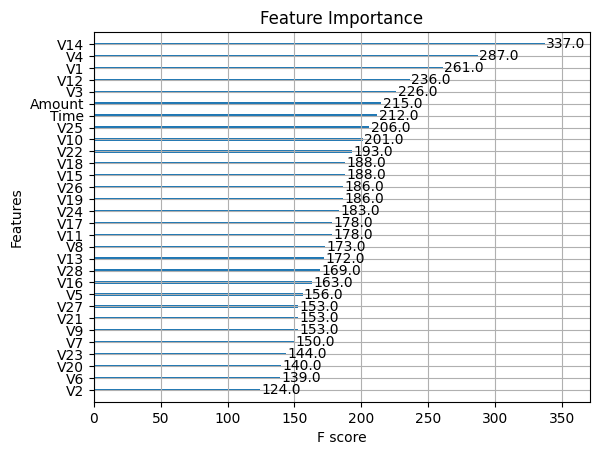

In [68]:
# Showing the most important features
model = xgb.XGBClassifier(n_estimators=200, random_state=42, eval_metric='logloss')
model.fit(X_resampled, y_resampled)
xgb.plot_importance(model, importance_type='weight', max_num_features=31)
plt.title("Feature Importance")
plt.show()


 Model: XGBOOST


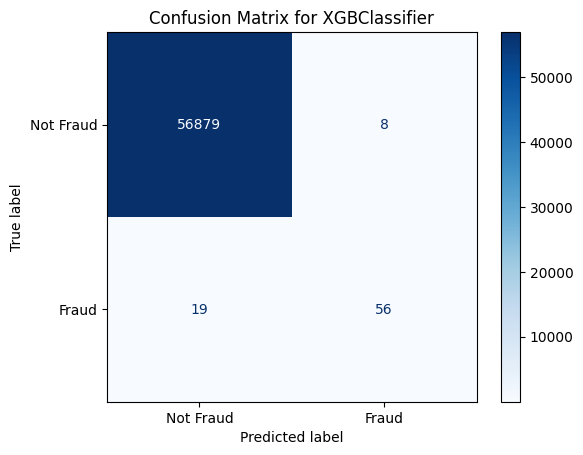


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.88      0.75      0.81        75

    accuracy                           1.00     56962
   macro avg       0.94      0.87      0.90     56962
weighted avg       1.00      1.00      1.00     56962



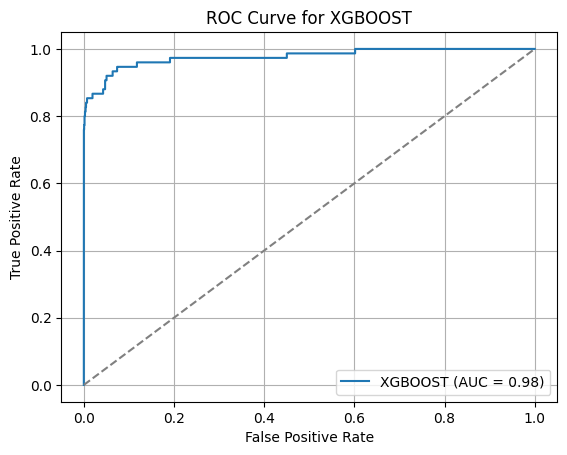

In [72]:
# Running the model
model = xgb.XGBClassifier(n_estimators=200, random_state=42, eval_metric='logloss')
run_model(df, model, "XGBOOST")

# Logistic Regression

In [46]:
# Oversampling experiment results can be found at:
# https://docs.google.com/document/d/1VCSaRQPcvjGzVNETezPAWO7yu2Gcmm_5nTvNxtn4vl0/edit?usp=sharing

# Leaving data imbalanced for Logistic Regression
X_resampled, y_resampled = X_train, y_train


 Model: Logistic Regression


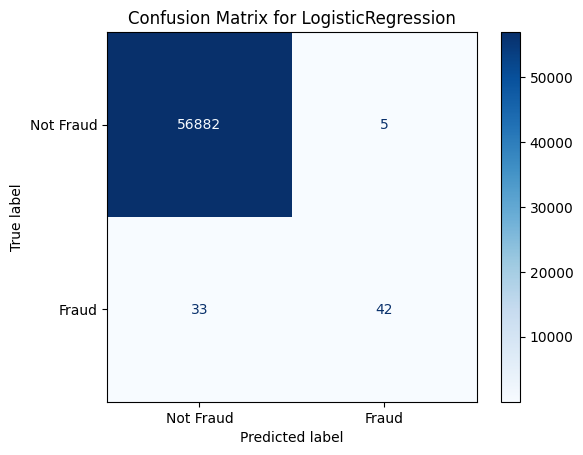


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.89      0.56      0.69        75

    accuracy                           1.00     56962
   macro avg       0.95      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962



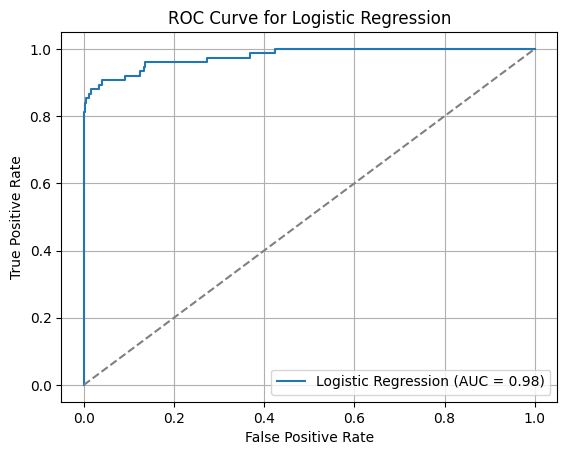

In [47]:
# Running the model
model = LogisticRegression(max_iter=1000)
run_model(df, model, "Logistic Regression")

# LGBM Classifier

In [69]:
# Oversampling experiment results can be found at:
# https://docs.google.com/document/d/1VCSaRQPcvjGzVNETezPAWO7yu2Gcmm_5nTvNxtn4vl0/edit?usp=sharing

# Using ADASYN for LGBM Classifier
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)


 Model: LGBM Classifier
[LightGBM] [Info] Number of positive: 227469, number of negative: 227428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454897, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500045 -> initscore=0.000180
[LightGBM] [Info] Start training from score 0.000180


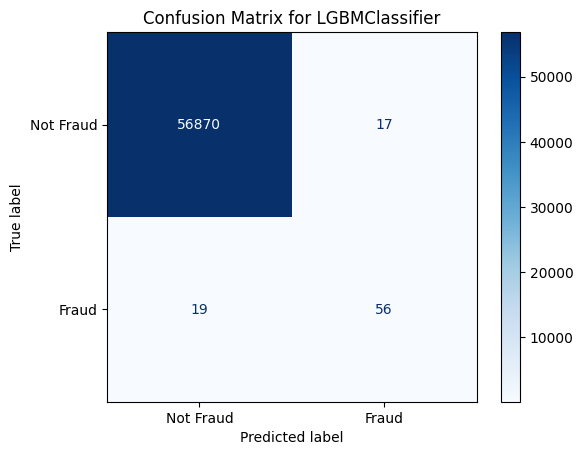


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.77      0.75      0.76        75

    accuracy                           1.00     56962
   macro avg       0.88      0.87      0.88     56962
weighted avg       1.00      1.00      1.00     56962



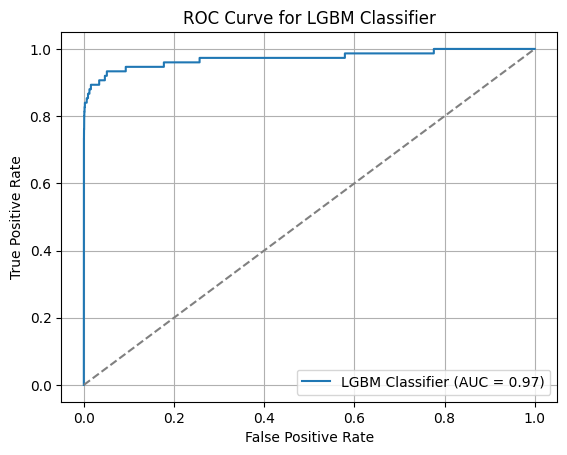

In [70]:
# Running the model

model = lgb.LGBMClassifier(n_estimators=200, random_state=42)
run_model(df, model, "LGBM Classifier")
